In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
base=automap_base ()
base.prepare (engine, reflect = True)
# reflect the tables
inspector=inspect(engine)
inspector.get_table_names ()

/var/folders/q0/gzzd0sss3kd_fyfy36xf2hnc0000gn/T/ipykernel_48069/690524817.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare (engine, reflect = True)


['measurement', 'station']

In [28]:
# View all of the classes that automap found
all_classes = base.classes

# Print the names of all classes
for class_name in all_classes.keys():
    print(class_name)




measurement
station


In [71]:
# Save references to each table
measurement=base.classes.measurement
station=base.classes.station

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [40]:
# Get a list of column names and types
columns = inspector.get_columns('station')

# Iterate over columns and print names and types
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [41]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')

# Iterate over columns and print names and types
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [43]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()

print("The most recent date in the dataset is:", most_recent_date)

The most recent date in the dataset is: 2017-08-23


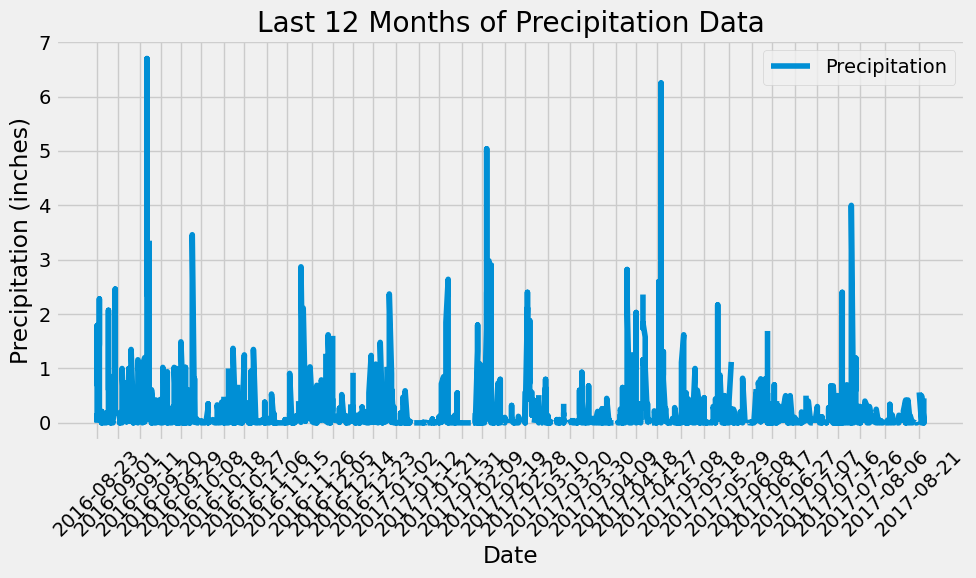

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= one_year_ago_str)\
    .order_by(measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
n = 60  # Display every 60th date
plt.xticks(df['Date'][::n], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [59]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()

print(f'Total number of stations in the dataset: {total_stations}')

Total number of stations in the dataset: 9


In [72]:
print(type(station))
print(type(measurement))


<class 'sqlalchemy.orm.decl_api.DeclarativeMeta'>
<class 'sqlalchemy.orm.decl_api.DeclarativeMeta'>


In [77]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Design a query to find the most active stations
active_stations = session.query(station.station, func.count(measurement.station))\
                        .join(measurement, station.station == measurement.station)\
                        .group_by(station.station)\
                        .order_by(func.count(measurement.station).desc())\
                        .all()

# Print the stations and their counts in descending order
print("Most active stations (descending order):")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most active stations (descending order):
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [78]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#1 Get the most active station ID from the previous query
most_active_station_id = active_stations[0][0]

#2 Query to calculate lowest, highest, and average temperature
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
                            .filter(measurement.station == most_active_station_id)\
                            .all()

#3 Print the results
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


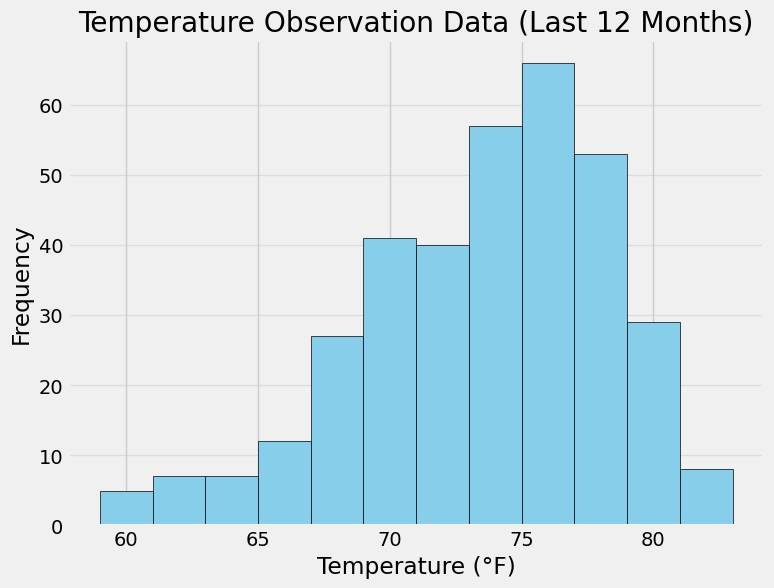

In [80]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Replace 'USC00519281' with the station ID obtained from the previous query

most_active_station_id = 'USC00519281'

# Calculate the date one year ago from the most recent date in the dataset
most_recent_date = session.query(func.max(measurement.date)).scalar()
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Perform a query to retrieve the TOBS data for the previous 12 months for the most active station
tobs_data = session.query(measurement.tobs)\
                    .filter(measurement.station == most_active_station_id)\
                    .filter(measurement.date >= one_year_ago)\
                    .all()

# Save the query results into a Pandas DataFrame
df = pd.DataFrame(tobs_data, columns=['Temperature'])

# Plot the results as a histogram with bins=12
plt.figure(figsize=(8, 6))
plt.hist(df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.title('Temperature Observation Data (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

# Close Session

In [16]:
# Close Session
session.close()

NameError: name 'session' is not defined